#### Importing all the necessary libraries

In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Function to read the data file and extract all the rows of data
def read_data(filename):
    with open(filename) as f:
        data = f.readlines()
    class_labels = []
    X = []
    for row in data:
        if ',' in row:
            d = row.split(',')
        if ' ' in row:
            d = row.split(' ')
        class_labels.append(d[-1][0])
        d = [float(d[i]) for i in range(len(d)-1) if d[i]!='']
        X.append(d)
    X = np.array(X)

    return X,class_labels

# Function for Expectation Maximization of Gaussian Mixture Models
def G_k(X,k,iterations,epsilon):
    
    '''
    Inputs
    X - The training data of shape - (n,d)
    k - The number of clusters
    iterations - The number of time steps
    epsilon - To keep track of algorithm convergence. Set at 0.001
    '''
    
    # The number of input dimensions
    d = X.shape[1]
    
    # The number of input samples
    n = X.shape[0]
    
    # Initializing mean vector for k clusters
    mu = np.random.normal(size = (k,d))
    
    # Initializing covariance matrices for k clusters
    sigma = []
    for i in range(k):
        sigma.append(np.eye(d))
    sigma = np.array(sigma)
    
    # Initializing prior probabilities for k clusters
    P = 1/k*np.ones(k)
    
    # Matrix that holds the posterior probabilities of every data sample in k clusters
    W = np.zeros((k,n))
    
    for itr in range(iterations):

        # EXPECTATION STEP
        for i in range(k):
            
            # Computing the posterior probability
            rv = multivariate_normal(mu[i].ravel(), sigma[i], allow_singular=True) 
            posterior = rv.pdf(X) * P[i]
            W[i] = posterior
        for j in range(n):
            W[:,j] = W[:,j]/np.sum(W[:,j])

        # MAXIMZATION STEP
        dist = 0
        for i in range(k): 
            
            # re-estimate mean
            sum_i = np.zeros(d)
            for j in range(n):
                sum_i = sum_i + W[i,j]*X[j]
            new_mu = sum_i / np.sum(W[i])
            dist = dist + np.sum(np.square(np.linalg.norm(new_mu - mu[i])))
            mu[i] = new_mu
          
            # re-estimate covariance
            cov = np.zeros((d,d))
            for j in range(n):
                diff = (X[j,:] - mu[i]).reshape(-1,1)
                cov = cov + W[i,j]*(diff @ diff.T)
            sigma[i] = cov / np.sum(W[i])

            # re-estimate priors
            P[i] = np.average(W[i])

               
        # Step to check if the algorithm has converged
        if dist<epsilon:
            break

    return mu,sigma,P, W, dist, itr+1

#### Function to find total error rate of classification done on real worls datasets

- Group all the data points based on their class labels (0 and 1) and compute the centroid of each class
- Find the Euclidean distance of each cluster centroid to the centroid of the actual class
- If a cluster is closer to class '0' then all points in that class are assigned a label of '0' and similarly for class '1'
- Once we have obtained the predicted labels, we compute the total number of mismatches (ie. the Total Error Rate)

In [47]:
def find_error(mu,W,class_labels,X):

    cluster_wise_labels = W.argmax(axis=0)    
        
    class_1_centroid = []
    class_2_centroid = []

    for i in range(X.shape[0]):

        if class_labels[i]==1: #g
            class_1_centroid.append(X[i,:])

        if class_labels[i]==0: #b
            class_2_centroid.append(X[i,:])

    class_1_centroid = np.average(np.array(class_1_centroid),axis=0)
    class_2_centroid = np.average(np.array(class_2_centroid),axis=0)   

    new_clusters = np.zeros(mu.shape[0])

    for i in range(mu.shape[0]):

        # Find euclidean distance between the cluster centroid and centroid of each of the classes
        dist1 = np.sum(np.square(mu[i]-class_1_centroid))
        dist2 = np.sum(np.square(mu[i]-class_2_centroid))

        if dist1 < dist2:
            new_clusters[i] = 1

        else:
            new_clusters[i] = 0

    predicted_labels = np.zeros(X.shape[0],dtype=int)
    for i in range(X.shape[0]):
        if new_clusters[cluster_wise_labels[i]]==1:
            predicted_labels[i]=1  


    # Find the total error - number of mismatches across both classes
    mismatches = 0
    for i in range(len(class_labels)):
        if class_labels[i]!=predicted_labels[i]:
            mismatches+=1
    
    return mismatches/len(class_labels) #total error rate 
        

Protocol for initializing each gaussian:

- Mean vector for each of the k clusters is initializing by randomly drawing samples from a normal distribution
    Mean - matrix of shape (k,d) - where d is the number of dimensions of the training data and k is the number of clusters
- Covariance matrices for each of the k clusters will be an identity matrix
    Covariance matrices has shape (k,d,d) - where d is the number of dimensions of the training data and k is the number of clusters
- Prior probabilities for each of the k clusters are intially given values 1/k - a vector of length k
- Posterior probabilities are stored in a matrix of size (k,n) - where k is the number of clusters and n is the number of data samples


Protocol for deciding ties:

- Find the proportion of data points that lie in each class. Since the 2 real world datasets considered in this problem have 2 classes we will have proportions p1 and p2 respectively for class 1 and class 2
- When there are more than 2 clusters we will have to reassign the labels of one of the clusters depending on its euclidean distance from the centroid of the 2 classes. Suppose the the cluster centroid is equally distant from the centroids of both classes we can compare which of the classes has a higher proportion. If p1> p2, all the points in a given cluster will be assigned the label of class '1' and class '2' label otherwise.


Stopping criteria:

- The EM algorithm can be repeatedly executed for a given number of iterations. In some situations, it is possible that the algorithm may converge much before the specified number of iterations. To ensure that the EM algorithms stops executing as soon as it has converged we use a paramerter - epsilon. 
- In the EM algorithm, we recompute the cluster centroids at every time step. To stop execution we check whether the summations of the squared difference of the previous centroid and the current centroid across all clusters is less than epsilon. ie:

    sum of (mu(t) - mu(t-1)) ** 2 for all k clusters < epsilon

## Problem 2: Analysis of the EM over Real-world Data Sets

#### Ionosphere Dataset

In [50]:
X, class_labels = read_data('ionosphere.data')
ground_truth_labels = np.zeros(X.shape[0],dtype=int)
for i in range(X.shape[0]):
    if class_labels[i]=='g':
        ground_truth_labels[i]=1

iterations_1 = {}
errors_1 = {}
for k in [2,3,4,5]:
    print("CURRENT k value: ",k)
    print("Number of iterations in each run = 30")
    df = pd.DataFrame(columns = ['Total Error', 'Convergence Loss', 'Stoppage Timestep'] )
    for _ in range(20):
        
        mu, sigma, P, W, dist, itr = G_k(X,k,30,1e-3)
        error = find_error(mu,W,ground_truth_labels,X)
        df = df.append({'Total Error': error, 'Convergence Loss' : dist, 'Stoppage Timestep': itr}, 
                ignore_index = True)
        
    iterations_1[k] = list(df['Stoppage Timestep'])
    errors_1[k] = list(df['Total Error'])
    print(df) 
    print()
    print("--------------------------------------------------")

CURRENT k value:  2
Number of iterations in each run = 30
    Total Error  Convergence Loss  Stoppage Timestep
0      0.344729          0.000006                5.0
1      0.501425          0.000012               14.0
2      0.122507          0.000461                8.0
3      0.330484          0.000113                5.0
4      0.387464          0.000010                4.0
5      0.227920          0.000015                9.0
6      0.358974          0.000065                7.0
7      0.384615          0.000431                9.0
8      0.262108          0.000055               12.0
9      0.205128          0.000369               15.0
10     0.430199          0.000660                9.0
11     0.199430          0.000129               12.0
12     0.321937          0.000052                4.0
13     0.111111          0.000230                9.0
14     0.356125          0.000361               11.0
15     0.068376          0.000258               11.0
16     0.407407          0.000005        

#### Ringnorm Dataset

In [42]:
X, class_labels = read_data('ringnorm/Dataset.data')
ground_truth_labels = np.zeros(X.shape[0],dtype=int)
for i in range(X.shape[0]):
    if class_labels[i]=='1':
        ground_truth_labels[i]=1
    
iterations_2 = {}
errors_2 = {}
for k in [2,3,4,5]:
    print("CURRENT k value: ",k)
    print("Number of iterations in each run = 50")
    df = pd.DataFrame(columns = ['Total Error', 'Convergence Loss', 'Stoppage Timestep'] )
    for _ in range(20):
        
        mu, sigma, P, W, dist, itr = G_k(X,k,50,1e-3)
        error = find_error(mu,W,ground_truth_labels,X)
        df = df.append({'Total Error': error, 'Convergence Loss' : dist, 'Stoppage Timestep': itr}, 
                ignore_index = True)
        
    iterations_2[k] = list(df['Stoppage Timestep'])
    errors_2[k] = list(df['Total Error'])
    print(df) 
    print()
    print("--------------------------------------------------")

CURRENT k value:  2
Number of iterations in each run = 50
    Total Error  Convergence Loss  Stoppage Timestep
0      0.014189          0.000275                9.0
1      0.014324          0.000207                7.0
2      0.014189          0.000140                7.0
3      0.014459          0.000362                6.0
4      0.014189          0.000150                9.0
5      0.015000          0.000596                7.0
6      0.014054          0.000095                7.0
7      0.014324          0.000862                9.0
8      0.015000          0.000498                7.0
9      0.014865          0.000563                7.0
10     0.014865          0.000543                8.0
11     0.014730          0.000690                6.0
12     0.014865          0.000840                6.0
13     0.014865          0.000599                8.0
14     0.014324          0.000189                8.0
15     0.015000          0.000415                7.0
16     0.014730          0.000441        

#### Whisker Plots to Analyze the performance

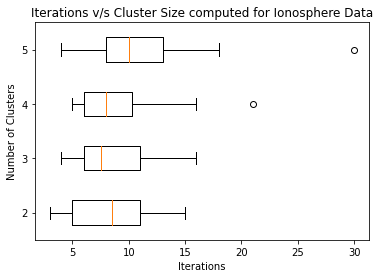

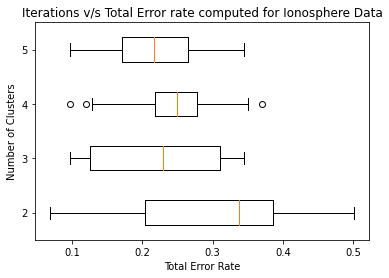

In [51]:
fig, ax = plt.subplots()
ax.boxplot(iterations_1.values(), vert = False)
ax.set_yticklabels(iterations_1.keys())
plt.title("Iterations v/s Cluster Size computed for Ionosphere Data")
plt.xlabel("Iterations")
plt.ylabel("Number of Clusters")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(errors_1.values(), vert = False)
ax.set_yticklabels(errors_1.keys())
plt.title("Iterations v/s Total Error rate computed for Ionosphere Data")
plt.xlabel("Total Error Rate")
plt.ylabel("Number of Clusters")
plt.show()

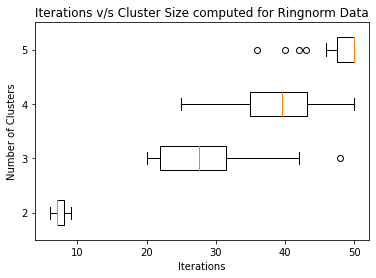

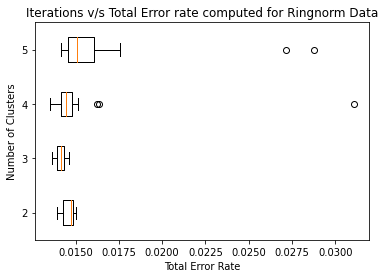

In [43]:
fig, ax = plt.subplots()
ax.boxplot(iterations_2.values(), vert = False)
ax.set_yticklabels(iterations_2.keys())
plt.title("Iterations v/s Cluster Size computed for Ringnorm Data")
plt.xlabel("Iterations")
plt.ylabel("Number of Clusters")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(errors_2.values(), vert = False)
ax.set_yticklabels(errors_2.keys())
plt.title("Iterations v/s Total Error rate computed for Ringnorm Data")
plt.xlabel("Total Error Rate")
plt.ylabel("Number of Clusters")
plt.show()